In [32]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.decomposition import *
from sklearn.model_selection import *
from xgboost import XGBClassifier
from math import *

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [33]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Описания полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

# EDA

In [34]:
# Целевая переменная - default. Разобъем переменные на интервальные и номинальные
num_cols = ['client_id','age','score_bki','income','decline_app_cnt','bki_request_cnt']
#'app_date'
cat_cols = ['education','sex','car','car_type','good_work','home_address','work_address','foreign_passport','region_rating','sna','first_time']
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
54379,74997,22MAR2014,GRD,M,25,N,N,0,0,-1.354615,2,80,2,3,60000,1,3,Y,0
42808,101097,18APR2014,SCH,F,67,N,N,0,0,-1.824009,4,40,2,3,25000,1,3,N,0
19753,76338,24MAR2014,GRD,M,22,N,N,0,0,-2.894768,2,80,2,3,60000,1,3,N,0
25794,48513,25FEB2014,SCH,M,33,N,N,0,0,-2.340169,1,50,1,3,40000,1,3,N,0
32333,40374,17FEB2014,GRD,F,68,N,N,0,0,-2.387268,1,60,1,1,70000,1,3,N,1


In [35]:
# Заполним пропуски
print(train.isnull().sum())
train['education'].fillna('OTH', inplace=True)
test['education'].fillna('OTH', inplace=True)
print(train.groupby('education')['default'].agg(['count','mean']))

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64
           count      mean
education                 
ACD          194  0.041237
GRD        23365  0.090092
OTH          307  0.114007
PGR         1257  0.064439
SCH        38860  0.150592
UGR         9816  0.131520


In [36]:
# Преобразуем app_date в дату
train['app_date'] = pd.to_datetime(train['app_date'])
test['app_date'] = pd.to_datetime(test['app_date'])

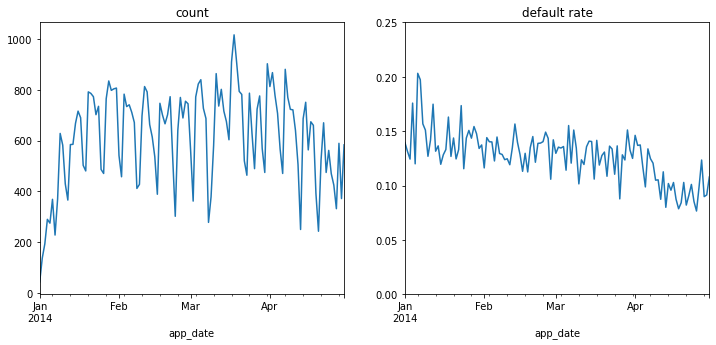

In [37]:
# В январские праздники объем выдач ниже среднего, риски повышенные т.к. за кредитами чаще обращаются клиенты с кассовым разрывом
# В апреле объемы выдач и дефолтность снижаются - возможно, менялась кредитная политика
fig, axes = plt.subplots(1, 2, figsize = (12,5))
train.groupby(['app_date'])['default'].count().plot(ax = axes[0], title = 'count')
train.groupby(['app_date'])['default'].mean().plot(ax = axes[1], title = 'default rate', ylim = (0,0.25));

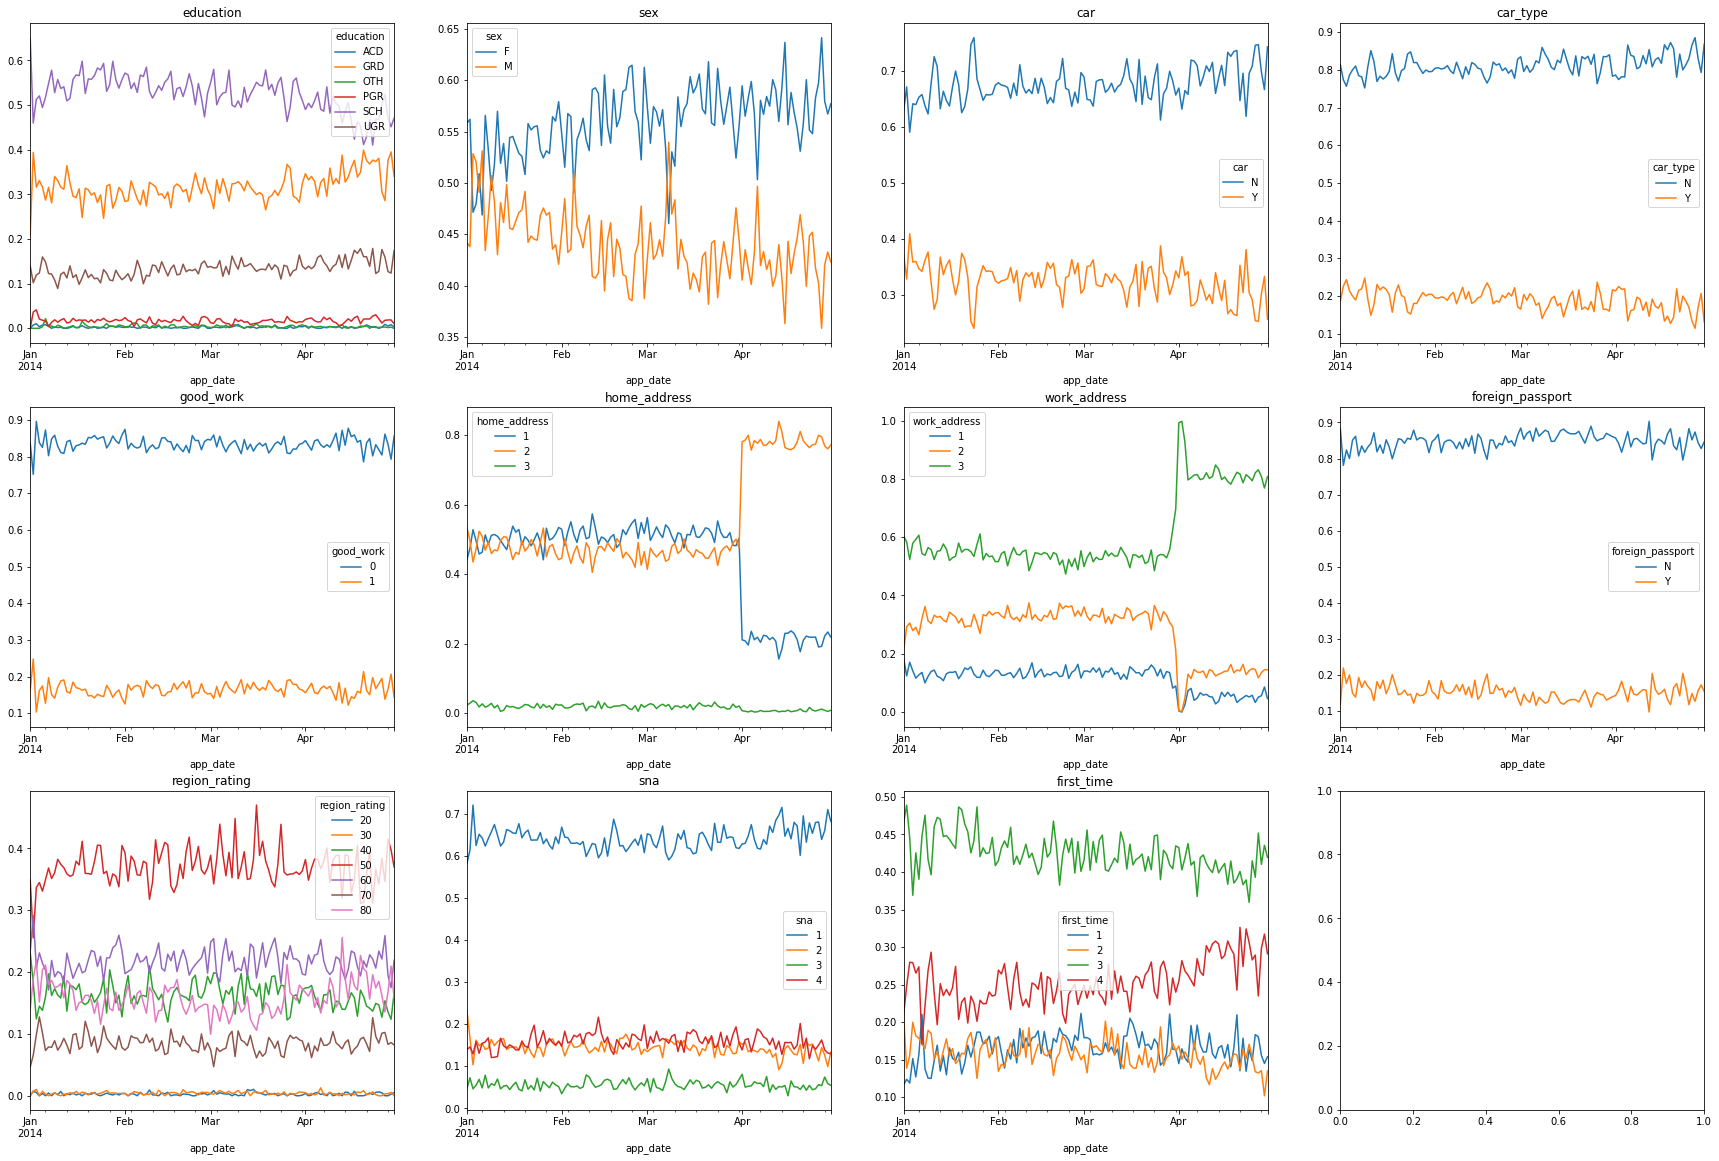

In [38]:
# Динамика долей номинальных признаков
# Распределение home_address и work_address сильно меняются в апреле - возможно, это следствие перехода на иную фронт-систему с другими справочникамии
# В апреле также снижается доля клиентов со школьным образованием в пользу выпускников c более низким риском
n = len(cat_cols)
col_num = 4
fig, axes = plt.subplots(ceil(n/col_num), col_num, figsize = (30,20))
i = 0
for col in cat_cols:
    ax = axes[floor(i / col_num), i % col_num]
    pd.crosstab(index = train['app_date'], columns = train[col], values = 'default', aggfunc = 'count', normalize = 'index').plot(ax = ax, title = col)
    i += 1

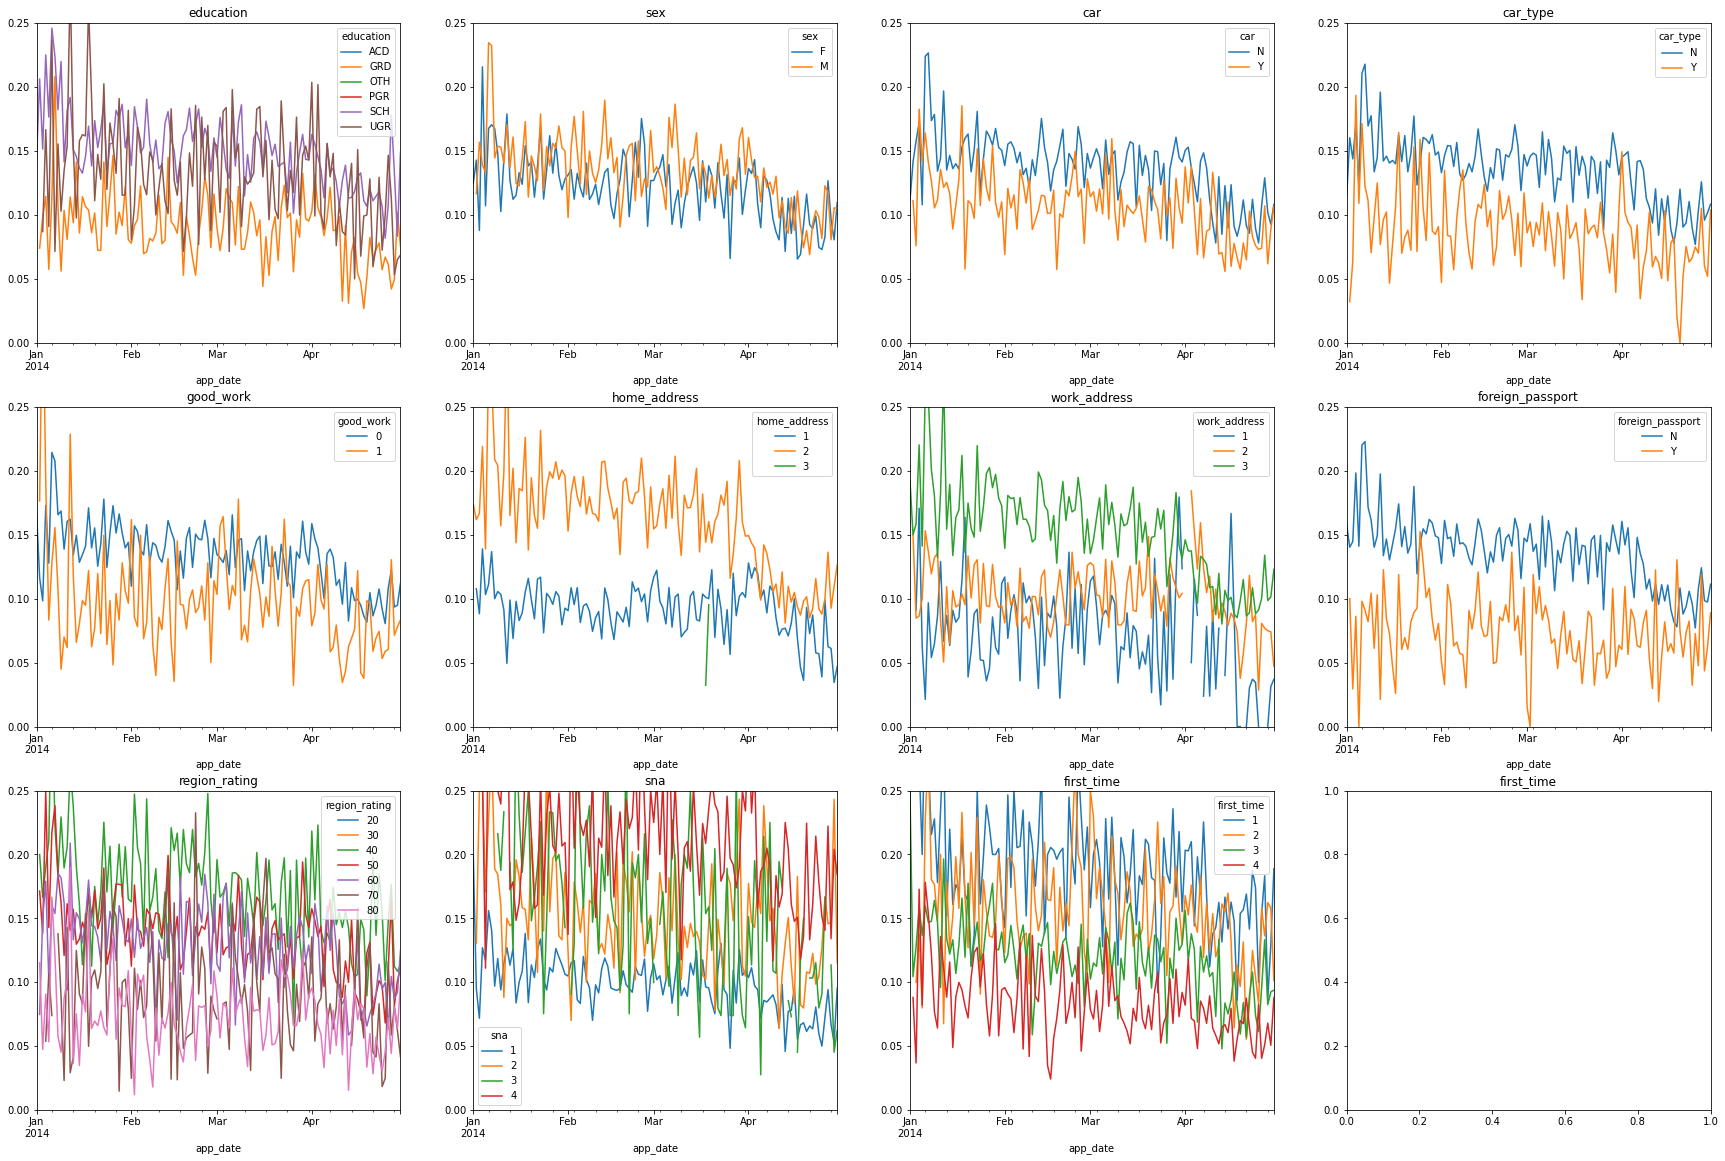

In [39]:
# Также в апреле падает предсказательная сила некоторых признаков, т.к. линии дефолтностей в разрезе их значений склевиаются
n = len(cat_cols)
col_num = 4
fig, axes = plt.subplots(ceil(n/col_num), col_num, figsize = (30,20))
i = 0
for col in cat_cols:
    ax = axes[floor(i / col_num), i % col_num]
    t = pd.crosstab(index = train['app_date'], columns = train[col], values = train['default'], aggfunc = 'count')
    pd.crosstab(index = train['app_date'], columns = train[col], values = train['default'], aggfunc = 'mean').mask(t < 20).plot(ax = ax, ylim = (0,0.25), title = col)
    plt.title(col)
    i += 1

In [40]:
train.groupby('education')['default'].agg(['count','mean']).sort_values(by = 'mean')

,count,mean
education,,
ACD,194,0.041237
PGR,1257,0.064439
GRD,23365,0.090092
OTH,307,0.114007
UGR,9816,0.131520
SCH,38860,0.150592


In [41]:
# Для изучения взаимосвязей между переменными заменим текстовые значения на числа
replacement = {'sex': {'F':0, 'M':1}, 'car': {'N':0, 'Y':1}, 'car_type': {'N':0, 'Y':1}, 'foreign_passport': {'N':0, 'Y':1},
               'education': {'ACD':0, 'PGR':1, 'GRD':2, 'OTH':3, 'UGR':4, 'SCH':5} }
train.replace(replacement, inplace = True)
test.replace(replacement, inplace = True)

In [42]:
train1 = train[train['app_date'] < pd.to_datetime('01APR2014')]
train2 = train[train['app_date'] >= pd.to_datetime('01APR2014')]
test1 = test[test['app_date'] < pd.to_datetime('01APR2014')]
test2 = test[test['app_date'] >= pd.to_datetime('01APR2014')]

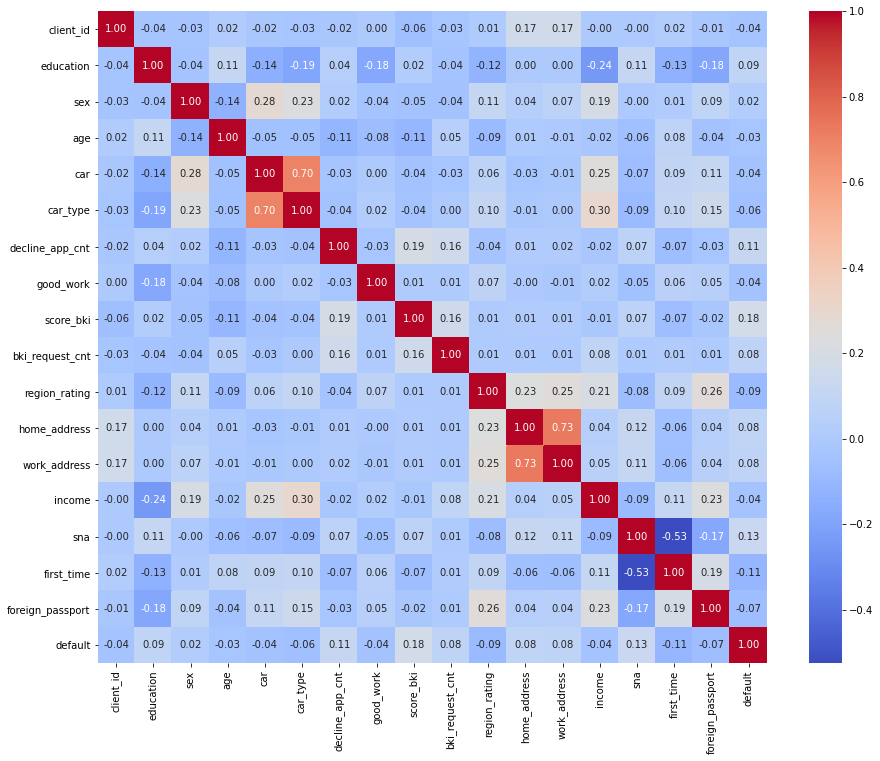

In [43]:
fig, ax = plt.subplots(figsize = (15,12))
sns.heatmap(train.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f');

In [44]:
# Признак car можно исключить, т.к. различия по риску между владельцами отечественных авто и клиентами без авто отсутствуют
cat_cols.remove('car')
train.groupby(['car','car_type'])['default'].agg(['count','mean'])

count      mean
car car_type                 
0   0         49832  0.136960
1   0          9959  0.132744
    1         14008  0.087450

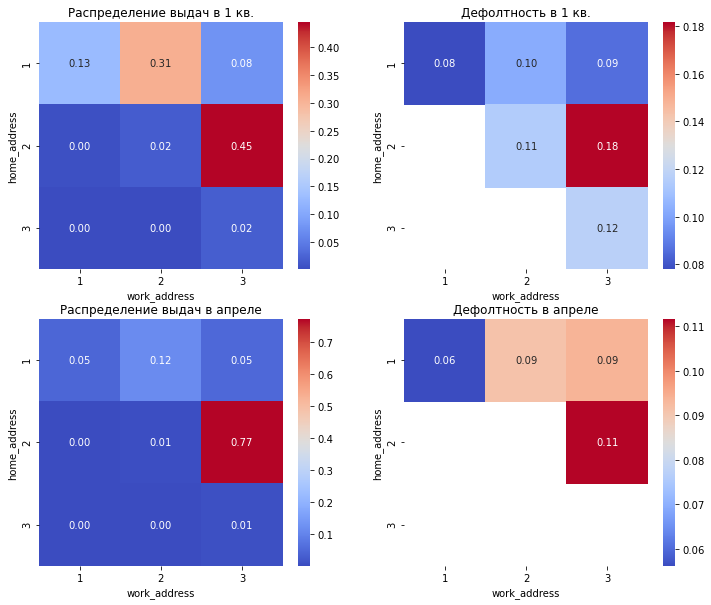

In [45]:
# Распределение выдач сконцентрировано в home_address = 1 и (home_address, work_address) = (2, 3). Также оно различается между 1 кв. и апрелем
# Можно объединить две переменные в одну с учетом этих наблюдений
fig, ax = plt.subplots(2,2, figsize = (12,10))

count1 = pd.crosstab(train1['home_address'], train1['work_address'], train1['default'], aggfunc = 'count', normalize = 'all')
sns.heatmap(count1, annot = True, cmap = 'coolwarm', fmt = '.2f', ax = ax[0,0]);
ax[0,0].set_title('Распределение выдач в 1 кв.')
sns.heatmap(pd.crosstab(train1['home_address'], train1['work_address'], train1['default'], aggfunc = 'mean').mask(count1 < 0.01), annot = True, cmap = 'coolwarm', fmt = '.2f', ax = ax[0,1]);
ax[0,1].set_title('Дефолтность в 1 кв.')

count2 = pd.crosstab(train2['home_address'], train2['work_address'], train2['default'], aggfunc = 'count', normalize = 'all')
sns.heatmap(count2, annot = True, cmap = 'coolwarm', fmt = '.2f', ax = ax[1,0]);
ax[1,0].set_title('Распределение выдач в апреле')
sns.heatmap(pd.crosstab(train2['home_address'], train2['work_address'], train2['default'], aggfunc = 'mean').mask(count2 < 0.01), annot = True, cmap = 'coolwarm', fmt = '.2f', ax = ax[1,1]);
ax[1,1].set_title('Дефолтность в апреле');

In [46]:
# Заменяем home_address и work_address на объединенную переменную address согласно логике, описанной выше
def address(row):
    k = 1
    n = 5
    if row['app_date'] >= pd.to_datetime('01APR2014'):
        k = -1
    if row['home_address'] == 1:
        n = row['work_address']
    if (row['home_address'] == 2) & (row['work_address'] == 3):
        n = 4
    return k * n

train['address'] = train.apply(lambda x: address(x), axis = 1)
test['address'] = test.apply(lambda x: address(x), axis = 1)

In [47]:
cat_cols.remove('home_address')
cat_cols.remove('work_address')
cat_cols.append('address')

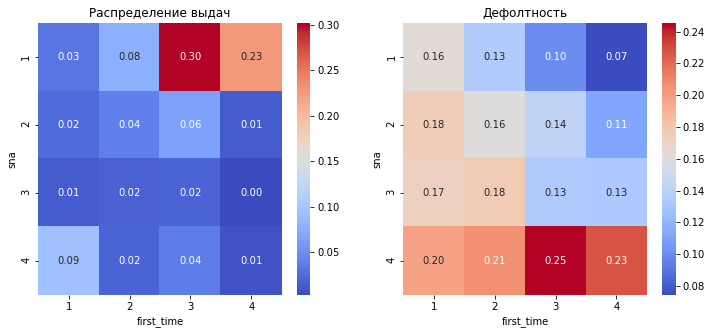

In [48]:
# Точной взаимосвязи между sna и first_time для снижения размерности не наблюдается
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.heatmap(pd.crosstab(train['sna'], train['first_time'], train['default'], aggfunc = 'count', normalize = 'all'), annot = True, cmap = 'coolwarm', fmt = '.2f', ax = ax[0]);
ax[0].set_title('Распределение выдач')
sns.heatmap(pd.crosstab(train['sna'], train['first_time'], train['default'], aggfunc = 'mean'), annot = True, cmap = 'coolwarm', fmt = '.2f', ax = ax[1]);
ax[1].set_title('Дефолтность');

In [49]:
# Сформируем попарные комбинации из категориальных переменных
comb_cols = []
for i in range(len(cat_cols)):
    for j in range(i+1,len(cat_cols)):
        var = 'comb: '+ cat_cols[i] + ' + ' + cat_cols[j]
        #train[var] = train.apply(lambda row : str(row[cat_cols[i]])+'_'+str(row[cat_cols[j]]), axis=1)
        #test[var] = test.apply(lambda row : str(row[cat_cols[i]])+'_'+str(row[cat_cols[j]]), axis=1)
        #comb_cols.append(var)
        #print(i,j,var)

# Modeling

In [50]:
# Создадим класс для вычисления Weight of Evidence
class WoE():
    def __init__(self):
        self.split = False
        pass
    
    def fit(self, data, var, response, split=False):
        if split == True: # Ветка для разбиения интервальных переменных
            self.clf = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 300).fit(data[[var]], data[response])
            p0 = data[response].mean()
            self.logit = np.log(p0/(1-p0))
        else:
            eps = 1e-10
            stat = data.pivot_table(values = list(set(data.columns) - {var,response})[0], columns = response, index = var, aggfunc=len, fill_value = 0)
            stat['share_0'] = stat[[0]] / stat[[0]].sum()
            stat['share_1'] = stat[[1]] / stat[[1]].sum()
            stat[var + '_w'] = np.log((stat['share_1'] + eps) / (stat['share_0'] + eps))
            self.stat = stat
            tmp = data[[var, response]].merge(stat[[var + '_w']], on = var, how = 'left')
            self = self.fit(tmp, var + '_w', response, split=True)
        self.split = split
        self.var = var
        return self
    
    def predict(self, data):
        w = self.var
        if self.split == False:
            if self.var + '_w' in data.columns:
                data.drop(columns=[self.var + '_w'],inplace=True)
            data = data.merge(self.stat[[self.var + '_w']], on = self.var, how = 'left')
            w = self.var + '_w'
            data[[w]] = data[[w]].fillna(0)
        eps = 1e-10
        p = self.clf.predict_proba(data[[w]])[:,1:2]
        data[self.var + '_woe'] = np.log((p+eps)/(1-p+eps)) - self.logit
        return data

In [51]:
# Готовим признаки для логистической регрессии
X_train, X_valid = train_test_split(train, test_size=0.30)

for col in cat_cols + comb_cols:
    print(col)
    woe = WoE().fit(X_train, col, 'default')
    X_train = woe.predict(X_train)
    X_valid= woe.predict(X_valid)
    test = woe.predict(test)
    
for col in num_cols:
    print(col)
    woe = WoE().fit(X_train, col, 'default', split=True)
    X_train = woe.predict(X_train)
    X_valid = woe.predict(X_valid)
    test = woe.predict(test)

education
sex
car_type
good_work
foreign_passport
region_rating
sna
first_time
address
client_id
age
score_bki
income
decline_app_cnt
bki_request_cnt


In [52]:
X_train.fillna(0, inplace=True)
X_valid.fillna(0, inplace=True)
test.fillna(0, inplace=True)

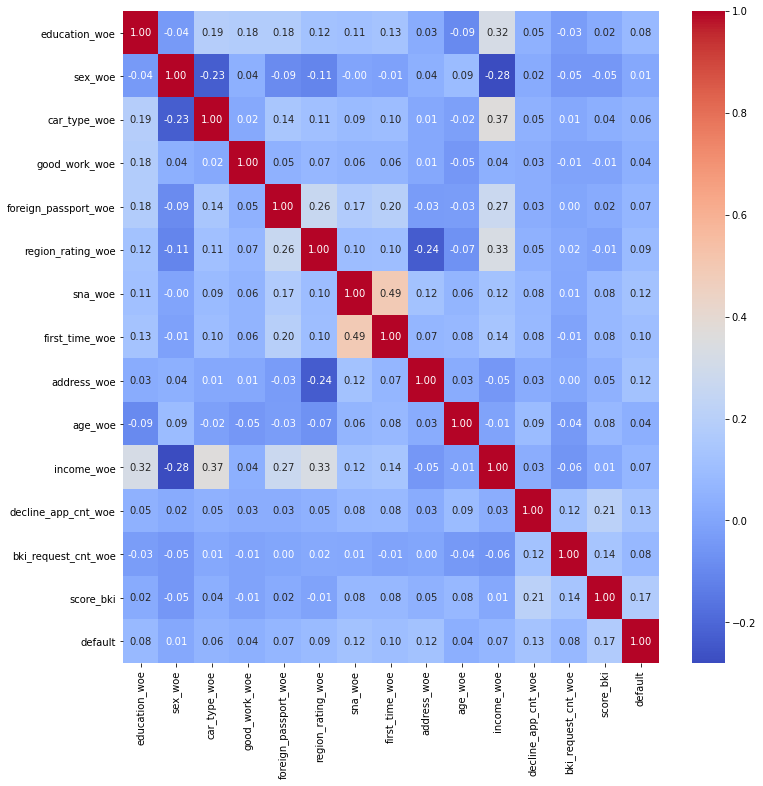

In [53]:
variables = [col for col in X_train.columns if ('woe' in col) and ('client_id' not in col)]
variables.append('score_bki')
variables.remove('score_bki_woe')

# Матрица корреляций WoE
fig, ax = plt.subplots(figsize = (12,12))
ax = sns.heatmap(X_train[variables + ['default']].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')

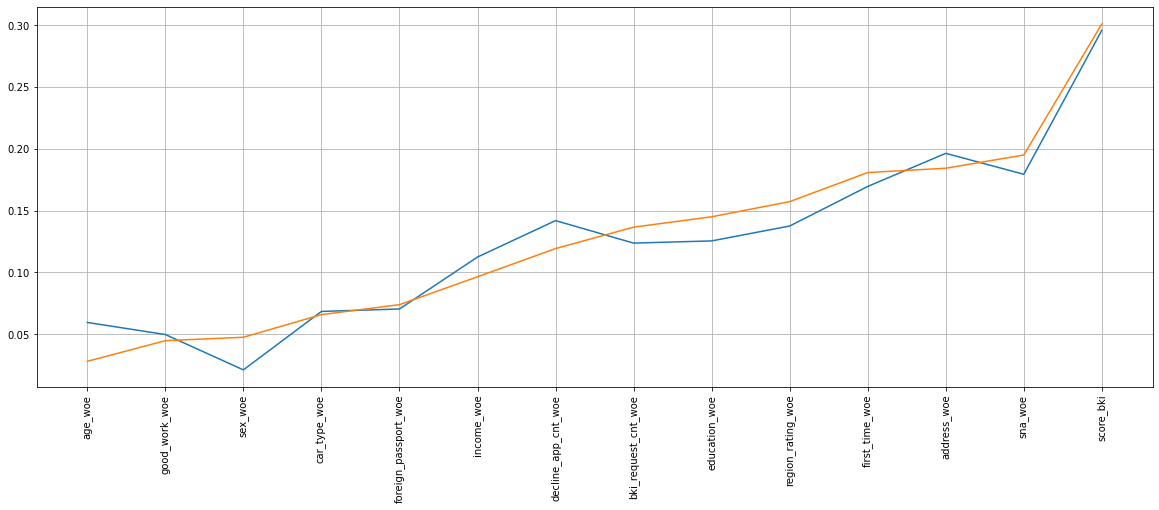

In [54]:
# Исходные переменные
fig, ax = plt.subplots(figsize = (20,7))
gini = pd.DataFrame({'train' : [roc_auc_score(X_train['default'], X_train[var])*2-1 for var in variables],
             'valid' : [roc_auc_score(X_valid['default'], X_valid[var])*2-1 for var in variables]}, index = variables).sort_values(by = 'valid')
plt.plot(gini)
ax.grid()
plt.xticks(gini.index, rotation=90);

Train AUC: 0.7350936061952533
Valid AUC: 0.7401211255536697


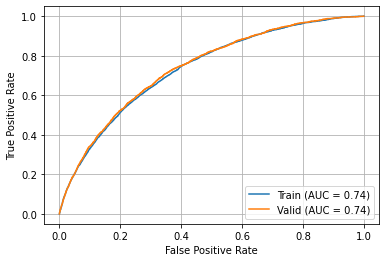

In [56]:
# Строим логистическую регрессию. Результат на валидационной выборке получается достаточно устойчивый
logreg = LogisticRegression(max_iter = 5000, C = 0.3, solver = 'saga', penalty = 'l1').fit(X_train[variables], X_train['default'])
plot_roc_curve(logreg, X_train[variables], X_train['default'], name = 'Train')
ax = plt.gca()
ax.grid()
plot_roc_curve(logreg, X_valid[variables], X_valid['default'], ax = ax, name = 'Valid')
print('Train AUC:',roc_auc_score(X_train['default'], logreg.predict_proba(X_train[variables])[:,1:]))
print('Valid AUC:',roc_auc_score(X_valid['default'], logreg.predict_proba(X_valid[variables])[:,1:]))

Train AUC: 0.7489679729283475
Valid AUC: 0.7424252456025664


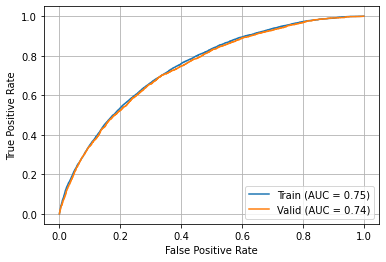

In [57]:
# Для сравнения строим модель на основе градиентного бустинга. 
# Стабильность на валидационной выборке получается хуже, чем у логистической регрессии, но применение данной модели позволяет подняться выше в рейтинге.
boost = XGBClassifier(max_depth = 2, learning_rate = 0.05, n_estimators = 700, subsample = 1).fit(X_train[variables], X_train['default'])
plot_roc_curve(boost, X_train[variables], X_train['default'], name = 'Train')
ax = plt.gca()
ax.grid()
plot_roc_curve(boost, X_valid[variables], X_valid['default'], ax = ax, name = 'Valid')
print('Train AUC:',roc_auc_score(X_train['default'], boost.predict_proba(X_train[variables])[:,1:]))
print('Valid AUC:',roc_auc_score(X_valid['default'], boost.predict_proba(X_valid[variables])[:,1:]))

In [58]:
X_train = train

for col in cat_cols + comb_cols:
    print(col)
    woe = WoE().fit(X_train, col, 'default')
    X_train = woe.predict(X_train)
    test = woe.predict(test)
    
for col in num_cols:
    print(col)
    woe = WoE().fit(X_train, col, 'default', split=True)
    X_train = woe.predict(X_train)
    test = woe.predict(test)

education
sex
car_type
good_work
foreign_passport
region_rating
sna
first_time
address
client_id
age
score_bki
income
decline_app_cnt
bki_request_cnt


Train AUC: 0.7479445184401465


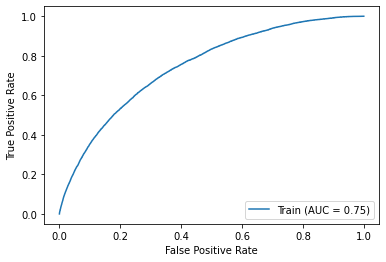

In [59]:
# Обучим теперь бустинг на всей выборке, чтобы получить более устойчивые оценки параметров
boost = XGBClassifier(max_depth = 2, learning_rate = 0.05, n_estimators = 700, subsample = 1).fit(X_train[variables], X_train['default'])
plot_roc_curve(boost, X_train[variables], X_train['default'], name = 'Train')
ax.grid()
print('Train AUC:',roc_auc_score(X_train['default'], boost.predict_proba(X_train[variables])[:,1:]))

In [60]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [61]:
test['default'] = boost.predict_proba(test[variables])[:,1:]
test[['client_id','default']].to_csv('submission.csv', index=False)

In [62]:
submission = pd.read_csv('/kaggle/working/submission.csv')
submission

,client_id,default
0,74835,0.028263
1,17527,0.261741
2,75683,0.078548
3,26883,0.080737
4,28862,0.020153
...,...,...
36344,83775,0.394554
36345,106254,0.022485
36346,81852,0.285037
36347,1971,0.267730
